In [1]:
#!pipenv install blackcellmagic --dev
#!pipenv install seaborn

In [2]:
%load_ext blackcellmagic

In [3]:
from CrawtoML import CrawtoML
import pandas
df = pandas.read_csv("train.csv")

In [4]:
l = list(df.columns)
l.remove("Survived")

In [5]:
for i in l:
    if df[i].dtype in ["float64","int64"]:
        print(i)

PassengerId
Pclass
Age
SibSp
Parch
Fare


In [6]:
automl = CrawtoML(
    data=df,
    target="Survived",
    problem='classification'
)

In [7]:
automl

	Target Column: Survived 
        Problematic Columns: ['PassengerId']
        Feature Columns: ['imputed_Cabin', 'imputed_Embarked', 'Pclass', 'Sex', 'SibSp', 'Parch']
        Numeric Columns: ['imputed_Age', 'Fare']
        Transformed Numeric Columns: ['log_imputed_Age', 'boxcox_imputed_Age', 'yeo_imputed_Age', 'yeo_Fare', 'inverted_imputed_Age']
        Imputed Columns: ['imputed_Age', 'imputed_Cabin', 'imputed_Embarked']
        NAN Columns:     ['Age', 'Cabin', 'Embarked']

In [8]:
automl.nan_report()

,Percent of data encoded NAN
PassengerId,0.00
Survived,0.00
Pclass,0.00
Name,0.00
Sex,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Ticket,0.00
Fare,0.00


AxesSubplot(0.125,0.125;0.775x0.755)


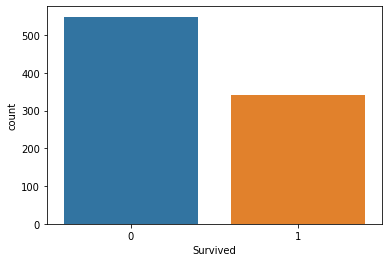

In [9]:
automl.target_distribution_report()

No Features are correlated above the threshold


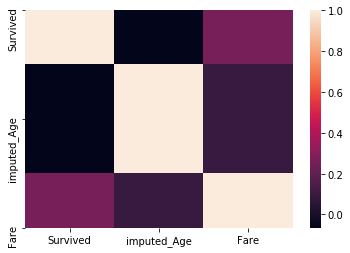

In [10]:
automl.correlation_report()

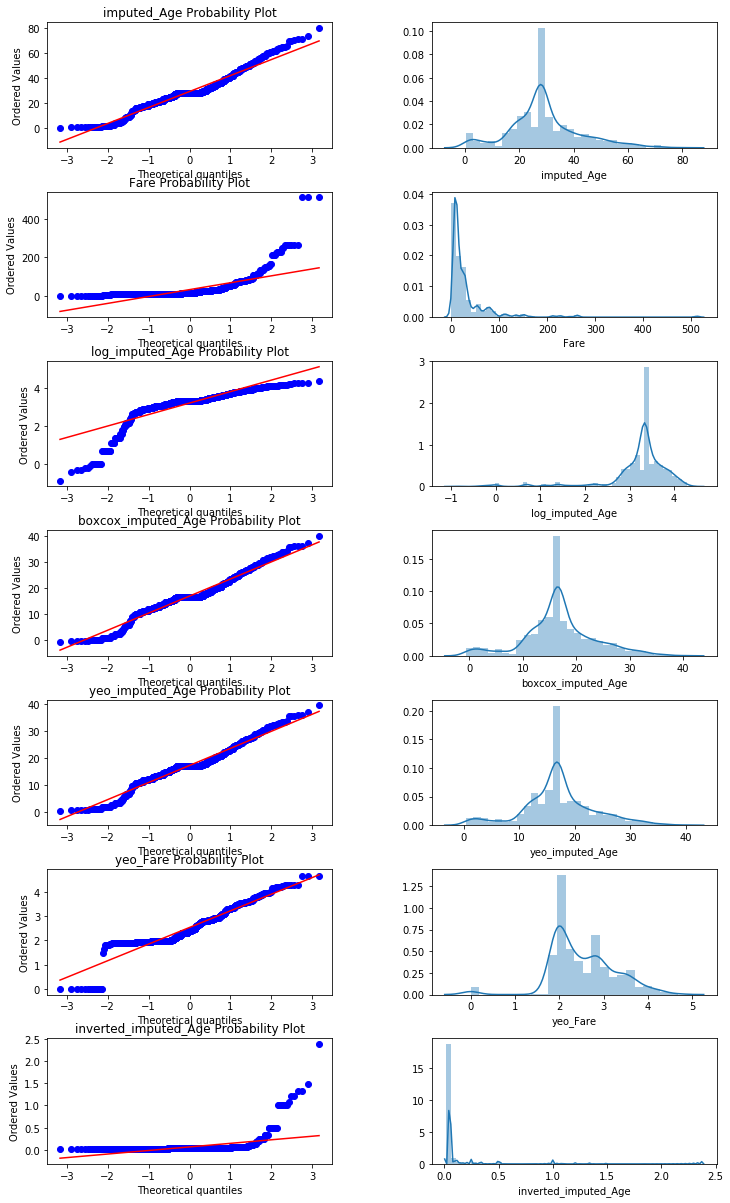

In [11]:
automl.probability_plots()

In [12]:
automl.distribution_r()

,Shapiro-Wilks_Test_Statistic,Shapiro-Wilks_p_Value,Normal distribution ?
imputed_Age,0.954105,4.650938e-16,False
Fare,0.521891,1.079000e-43,False
Survived,0.616660,1.794531e-40,False


# Experiments

### Notes
normal_test